In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0293_4_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_7.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2511_4_13.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_9627_8_9.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_7_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2977_3_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0254_9_6.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2016_1_11.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2010_2_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_1424_5_16.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2979_8_8.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0472_10_10.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_0471_3_5.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2015_11_3.jpg
/kaggle/input/surface-crack/valid/Negative/IMG_2626_8_7.jpg
/kaggle/input/surface-crack/valid

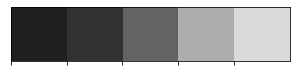

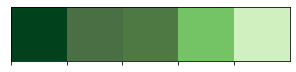

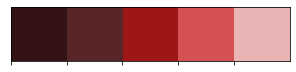

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

mentioning the labels in a list

In [3]:
labels=['Negative','Positive']

In [4]:
X_train = []
y_train = []
image_size = 200
for i in labels:
    folderPath = os.path.join('/kaggle/input/surface-crack','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
for i in labels:
    folderPath = os.path.join('/kaggle/input/surface-crack','valid',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
for i in labels:
    folderPath = os.path.join('/kaggle/input/surface-crack','test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 100/100 [00:00<00:00, 156.41it/s]


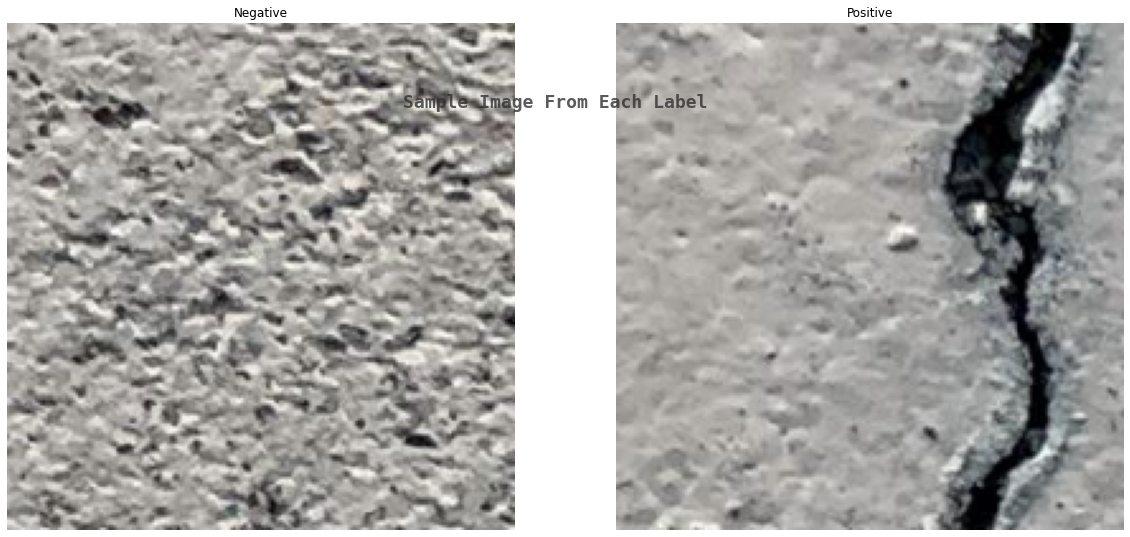

In [5]:
k=0
fig, ax = plt.subplots(1,2,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(1000, 200, 200, 3)

splitting the images into train and test respectively

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

One hot encoding this shit

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Transfer learning using EfficientNet 

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the EfficientNetB0 model which will use the weights from the ImageNet dataset.

The include_top parameter is set to False so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [10]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

2023-01-12 09:47:28.575484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 09:47:28.669181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 09:47:28.670109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 09:47:28.671452: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 2s 0us/step


head for predicting the output from the transfer learning pretrained model

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(2,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

summary of the final model

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 200, 200, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 200, 200, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 201, 201, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
model.compile(loss='binary_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Callbacks -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.

By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using TensorBoard, ModelCheckpoint and ReduceLROnPlateau callback functions

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

2023-01-12 09:47:35.304282: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-12 09:47:35.304843: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-12 09:47:35.306893: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-01-12 09:47:35.614959: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-12 09:47:35.615734: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [15]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2023-01-12 09:47:36.251095: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2023-01-12 09:47:45.257994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/26 [>.............................] - ETA: 6:16 - loss: 0.7850 - accuracy: 0.5000

2023-01-12 09:47:51.584033: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-12 09:47:51.584084: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/26 [=>............................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5781 

2023-01-12 09:47:52.119335: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-12 09:47:52.122142: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-12 09:47:52.277887: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2140 callback api events and 2137 activity events. 
2023-01-12 09:47:52.327942: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-12 09:47:52.391647: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2023_01_12_09_47_52

2023-01-12 09:47:52.431426: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.trace.json.gz
2023-01-12 09:47:52.518928: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

 3/26 [==>...........................] - ETA: 15s - loss: 0.6553 - accuracy: 0.6146

2023-01-12 09:47:52.533226: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2023_01_12_09_47_52
Dumped tool data for xplane.pb to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.tensorflow_stats.pb
Dumped tool data for kernel_stats.pb to logs/train/plugins/profile/2023_01_12_09_47_52/565b1d20c1bf.kernel_stats.pb



26/26 [==============================] - 22s 290ms/step - loss: 0.2086 - accuracy: 0.9086 - val_loss: 0.0401 - val_accuracy: 1.0000

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to effnet.h5
Epoch 2/12
26/26 [==============================] - 5s 182ms/step - loss: 0.0319 - accuracy: 0.9914 - val_loss: 0.0289 - val_accuracy: 0.9889

Epoch 00002: val_accuracy did not improve from 1.00000
Epoch 3/12
26/26 [==============================] - 5s 183ms/step - loss: 0.0236 - accuracy: 0.9914 - val_loss: 0.1136 - val_accuracy: 0.9889

Epoch 00003: val_accuracy did not improve from 1.00000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
26/26 [==============================] - 5s 181ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0502 - val_accuracy: 0.9889

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/12
26/26 [==============================] - 5s 179ms/step - loss: 0.0174 - accuracy: 0.9951 - val_los

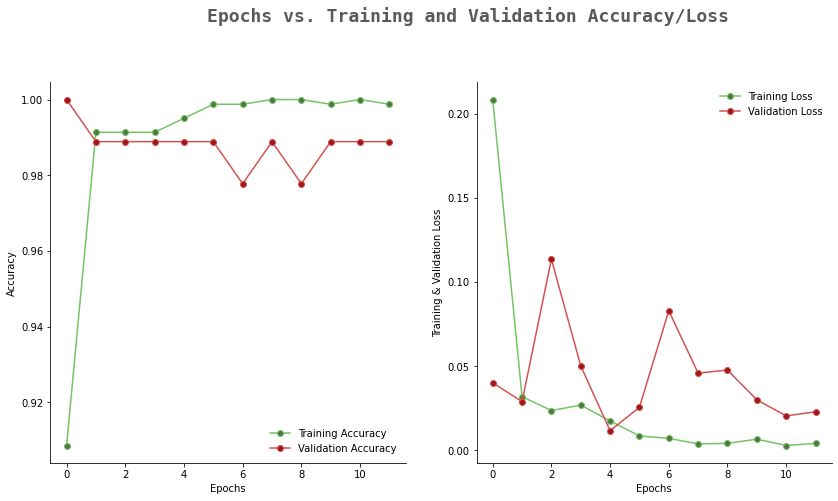

In [16]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()


argmax function as each row from the prediction array contains tqo  values for the respective labels. The maximum value which is in each row depicts the predicted output out of the 2 possible outcomes.
So with argmax, I'm able to find out the index associated with the predicted outcome.

In [17]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [18]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        49

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

